In [ ]:
###########################################################################
# Copyright 2022 Jean-Luc CHARLES
# Created: 2022-12-04
# version: 1.1 - 7 Dec 2022 
# License: GNU GPL-3.0-or-later
###########################################################################

# <img align="left" src="./images/movie_camera.png" width="40" height="40">_Deep Reinforcement Learning_ (DRL) to train a PPO neural network control the robot position.

In this notebook you will learn how to use the DRL to train a ___PPO___  neural network to control the robot position.

# <img align="left" src="./images/film_reel.png" width="40" height="40">$\,$Outline <a name="top"></a>
- [ 1 $-$ The RoboticArm_2DOF class](#1)
    - [ 1.1 $-$ Instancite the robot](#1.1)
    - [ 1.2 $-$ Run a simple test](#1.2)
- [ 2 $-$ Train the PPO neural network](#2)
    - [ 2.1 $-$ A first _fake_ training to see](#2.1)
    - [ 2.2 $-$ Run the full training](#2.2)
    - [ 2.3 $-$ Find the best training epoch](#2.3)
    - [ 2.4 $-$ Evaluate the trained agent performance](#2.4)

Recommended links:
- Pybullet online documentation: [PyBullet Quickstart Guide](https://docs.google.com/document/d/10sXEhzFRSnvFcl3XxNGhnD4N2SedqwdAvK3dsihxVUA/edit#heading=h.2ye70wns7io3)

# Import the required modules

In [1]:
import os, sys, time, shutil, yaml, pathlib, shutil
import pybullet as p
import pybullet_data
import numpy as np
from numpy.linalg import norm       # to get the norm of a vector
from numpy import pi
import matplotlib.pyplot as plt

from utils.tools import is_close_to, display_joint_properties, test_training, sample_line, sample_traj4pts
from utils.tools import welcome, plot_test, moving_average, get_files_by_date
from utils.RoboticArm_2DOF import RoboticArm_2DOF_PyBullet

# the PyBullect connection:
pc = None

pybullet build time: May 20 2022 19:44:17


# 1. $-$ The RoboticArm_2DOF_PyBullet class <a name="1"></a>

The RoboticArm_2DOF class inherits from the base class `env` of the framework _Gym_.<br>
It is defined in the file `utils/RoboticArm_2DOF.py` with main tasks : 
- Create an instance of the Env class.
- Create a PyBullet session.
- Instanciate the 2 DOF robot arm in the simulator session using its URDF file.
- Make the simulated robot move under the actions gven by the PPO agent.. 

## 1.1 $-$ Instanciate the robot <a name="1.1"></a>

In [2]:
URDF   = "./urdf/RoboticArm_2DOF_2.urdf"
TARGET = "./urdf/target.urdf"

if 'env' in dir(): 
    env.close()
    del env

env = RoboticArm_2DOF_PyBullet(robot_urdf = URDF,       # mandatory
                               target_urdf = TARGET,    # mandatory
                               dt = 0.002,              # mandatory
                               headless = False,        # to get the PyBullet graphical interface 
                               verbose=2)

[RoboticArm_2DOF_PyBullet.__init__] _max_episode_steps:500

################################################################################
# Welcome to this practical session with Pybullet & URDF.
# Pybullet windows shortcuts:
#    G: close/open the tabs
#    W: switch between solid/wireframe rendering
#    J: show/hide links & joints frames as RGB lines (with wireframe rendering actvated)
#    K: show/hide joint axes as a black line         (with wireframe rendering actvated)
#    A: show/hide collision boxes                    (with wireframe rendering actvated)
#    CTRL+left_clic  : rotate the robot
#    CRTL+midlle_clic: translate the robot
#    Mouse_wheel: zoom/unzoom
################################################################################



/home/jlc/work/miniconda3/envs/pydrl/lib/python3.8/site-packages/gym/spaces/box.py:73: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(


## 1.2 - Run a simple kinematic test<a name="1.2"></a>

In this test, the two DOFs of the robot (angles $q_1$ and $q_2$) are controlled by value to make the robot move around its start position.

In [3]:
data = env.testAngleControl(0.075)

[RoboticArm_2DOF_PyBullet.reset] last #steps : 0
[RoboticArm_2DOF_PyBullet.reset] q1:(144.3°, 0.0°/s), q2:(-138.8°, 0.0°/s), Target:(0.784,0.764) m, EndEff:(0.183,0.699) m, after 2 substeps
[testAngleControl] Ready to run the test with timestep=7.50e-02 s
[testAngleControl] Press ENTER to launch the free run simulation...
sub_steps: 2
-0.00°°

#### Plot the data:

We can verify that tha actual values of $q_1$ and $q_2$ are close to the tagrte values (dashed black lines).<br>
We also draw the velocities $\dot{q}_1$ and $\dot{q}_2$, as well as the trajectory of the end effector of the robot:

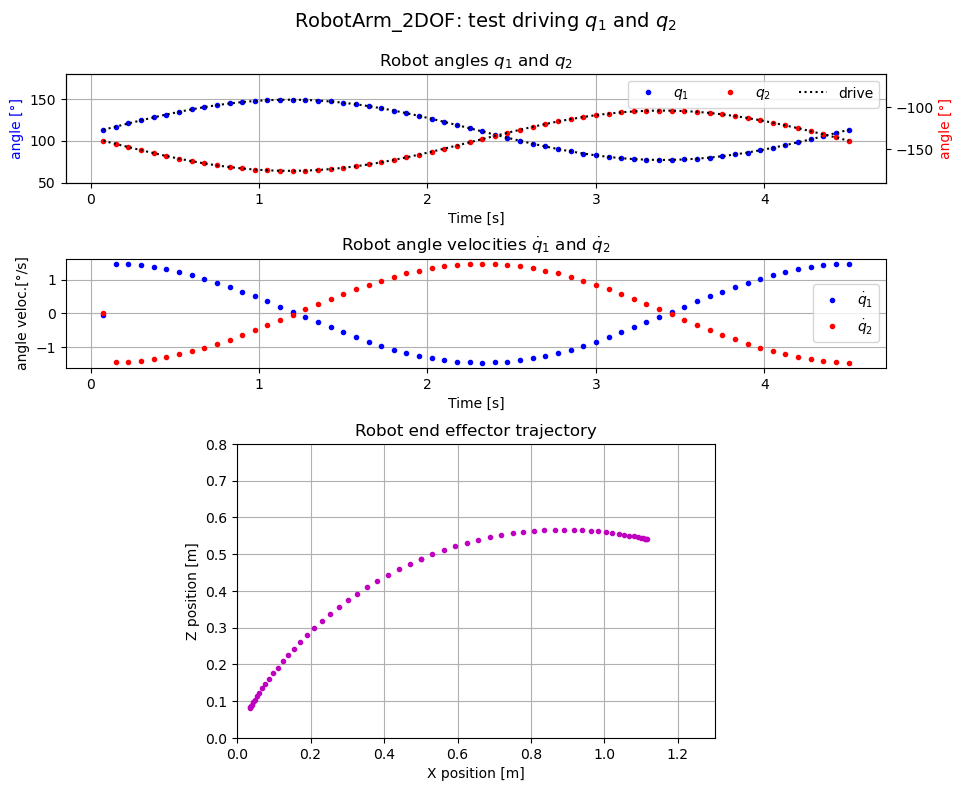

In [4]:
data = data.astype(float)
plot_test(data)

### Try the reset() method

In [5]:
obs = env.reset(options={"target_initial_pos":(0.50, 0, 0.50), 'randomize':True})

[RoboticArm_2DOF_PyBullet.reset] last #steps : 60
[RoboticArm_2DOF_PyBullet.reset] q1:(87.4°, 0.0°/s), q2:(-171.4°, 0.0°/s), Target:(0.510,0.044) m, EndEff:(0.150,0.025) m, after 2 substeps


In [6]:
obs = env.reset(options={"target_initial_pos":(0.50, 0, 0.50), 'randomize':True})

[RoboticArm_2DOF_PyBullet.reset] last #steps : 0
[RoboticArm_2DOF_PyBullet.reset] q1:(128.1°, 0.0°/s), q2:(-164.4°, 0.0°/s), Target:(0.916,0.882) m, EndEff:(0.189,0.215) m, after 2 substeps


In [7]:
obs = env.reset(options={"target_initial_pos":(0.50, 0, 0.50), 'randomize':False})

[RoboticArm_2DOF_PyBullet.reset] last #steps : 0
[RoboticArm_2DOF_PyBullet.reset] q1:(113.0°, 0.0°/s), q2:(-140.0°, 0.0°/s), Target:(0.500,0.500) m, EndEff:(0.500,0.487) m, after 2 substeps


In [8]:
obs = env.reset(options={"target_initial_pos":(0.50, 0, 0.50), 'randomize':False})

[RoboticArm_2DOF_PyBullet.reset] last #steps : 0
[RoboticArm_2DOF_PyBullet.reset] q1:(113.0°, 0.0°/s), q2:(-140.0°, 0.0°/s), Target:(0.500,0.500) m, EndEff:(0.500,0.487) m, after 2 substeps


### Close the envrironment

When you have done with the `env` object, before creating another `RoboticArm_2DOF_PyBullet` it is important to close the current `env` properly in order to close the Pybullet session ans all what is connected with the environment.

In [9]:
env.close()

[top](#top)

# 2 - Train the PPO neural network <a name="2"></a>

#### Training Strategy

The training of the robot involves a loop on the target position:
- A random target position is choosen in the space reachable by the robot.
- During the training, the reward function encourages the robot to move its end effector as close as possible to the target position.
- When done (the end effector is close enough to the target), a new target position is randomly choosen, and so on...

The whole training process is driven by many __hyperparameters__ including:
- `tot_steps`: the total number of random positions learned before we decide that the network is trained.
- `EPSILON`: the distance between the end effector and the target mass below which the effector is considered close enough to the target.
- `n_epoch`: the (classical) number of training runs with the same data set.

## 2.1 A first _fake_ training to see <a name="2.1"></a>

You will run now a first _fake_ training to see if all is OK : the purpose of this section is just to show you the steps of a DRL training scenario. <br>
At this stage, you will use the __reward function__ `reward_0` already defined in the file `reward.py` : it returns always 0, so the PPO agent wil not learn anything....<br>

### 2.1.1 Instanciate the robot <a name="2.1.1"></a>

#### Let's define important parameters:

In [10]:
DT      = 0.002          # the simulation time step
EPSILON = 1e-3           # the distance threshold betwwen the end effector and the target
SEED    = 1234567        # the sedd for the random generators

Create an instance of `RoboticArm_2DOF_PyBullet`:

In [11]:
URDF   = "./urdf/RoboticArm_2DOF_2.urdf"
TARGET = "./urdf/target.urdf"

if 'env' in dir():
    try:
        env.close()
    except:    
        del env

env    = RoboticArm_2DOF_PyBullet(robot_urdf  = URDF, 
                                  target_urdf = TARGET, 
                                  dt = DT,
                                  init_robot_angles = (113, -140),
                                  init_target_pos = (0.5, 0, 0.5),
                                  reward = 'reward_0',
                                  seed = SEED,
                                  epsilon = EPSILON,
                                  headless = False,  # we kep the graphical rendering for this 'fake' round
                                  max_episode_steps = 500,
                                  verbose=0)

not connected...

################################################################################
# Welcome to this practical session with Pybullet & URDF.
# Pybullet windows shortcuts:
#    G: close/open the tabs
#    W: switch between solid/wireframe rendering
#    J: show/hide links & joints frames as RGB lines (with wireframe rendering actvated)
#    K: show/hide joint axes as a black line         (with wireframe rendering actvated)
#    A: show/hide collision boxes                    (with wireframe rendering actvated)
#    CTRL+left_clic  : rotate the robot
#    CRTL+midlle_clic: translate the robot
#    Mouse_wheel: zoom/unzoom
################################################################################



### 2.1.2 Instanciate the PPO network <a name="2.1.2"></a>

Let's define the PPO training hyperparameters:

In [12]:
policy     = 'MlpPolicy'
tot_steps  = 20000       # 'just' 20000 steps for this 'fake' round
save_freq  = 5000        # save the networks weights every 'save_freq' steps
nb_steps   = 2048        # The number of steps to run per update (the size of the rollout buffer)
nb_epochs  = 10          # number of training iterations with the same dataset
batch_size = 256         # size of the batch to train the network

Define automatically a uniq name for the training directory:

In [13]:
experiment_time = time.localtime()
experiment_id = "_".join(['2DOF_RobotArm_PyBullet', 'PPO', time.strftime("%y-%m-%d_%H-%M-%S", experiment_time)])

training_dir = pathlib.Path('models')/experiment_id
training_dir.mkdir(parents=True, exist_ok=True)

print(f"Training in directory <{training_dir}>")

Training in directory <models/2DOF_RobotArm_PyBullet_PPO_23-09-27_20-17-51>


Create the PPO neural network:

In [14]:
from stable_baselines3 import PPO
from stable_baselines3.common.callbacks import CheckpointCallback

agent = PPO(policy, 
            env, 
            n_epochs = nb_epochs,
            n_steps = nb_steps,
            batch_size = batch_size,
            use_sde = False,
            seed = SEED,
            tensorboard_log = training_dir,
            verbose=1)

checkpoint_callback = CheckpointCallback(save_freq = save_freq, 
                                         save_path = training_dir/'ZIP')

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


Now train the network<br>
(you can find an explanation of the training display here : https://stable-baselines3.readthedocs.io/en/master/common/logger.html#rollout)


In [15]:
# train agent
t0 = time.time()

agent.learn(total_timesteps=tot_steps, callback=checkpoint_callback)
    
t = int(time.time()-t0)
h = int(t/3600)
m = int((t - h*3600)/60)
print(f"Training elapsed time: {h:02d}h {m:02d}m")

Logging to models/2DOF_RobotArm_PyBullet_PPO_23-09-27_20-17-51/PPO_1
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 500      |
|    ep_rew_mean     | 0        |
| time/              |          |
|    fps             | 464      |
|    iterations      | 1        |
|    time_elapsed    | 4        |
|    total_timesteps | 2048     |
---------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 500         |
|    ep_rew_mean          | 0           |
| time/                   |             |
|    fps                  | 465         |
|    iterations           | 2           |
|    time_elapsed         | 8           |
|    total_timesteps      | 4096        |
| train/                  |             |
|    approx_kl            | 0.005183859 |
|    clip_fraction        | 0.0348      |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.84       |
|  

Training elapsed time: 00h 00m


#### $\blacktriangleright$ Check target positions:

$\blacktriangleright$  Using the coordinates `x`and `z` of the attribut `target_pos` of `env` object, try to plot the successive positions of the target during training:

In [16]:
env.target_pos

[array([1.00352512, 0.        , 0.23244807]),
 array([0.83687364, 0.        , 0.65025068]),
 array([0.40627127, 0.        , 0.26032   ]),
 array([0.04953405, 0.        , 0.43108825]),
 array([0.2941156, 0.       , 0.1018621]),
 array([0.15812045, 0.        , 0.22887098]),
 array([0.83247334, 0.        , 0.97586681]),
 array([0.42635813, 0.        , 0.92096292]),
 array([0.49166868, 0.        , 0.84628176]),
 array([0.79444511, 0.        , 0.71840541]),
 array([1.00644166, 0.        , 0.26731939]),
 array([-0.00030894,  0.        ,  0.18974063]),
 array([0.81300869, 0.        , 0.61208005]),
 array([0.08881326, 0.        , 0.83103712]),
 array([0.75332394, 0.        , 0.62814082]),
 array([0.95536551, 0.        , 0.58393175]),
 array([0.7969272 , 0.        , 0.61791811]),
 array([1.00044267, 0.        , 0.58126829]),
 array([0.50589851, 0.        , 0.76938456]),
 array([0.9236294 , 0.        , 0.95540639]),
 array([0.42152503, 0.        , 0.20507741]),
 array([0.15524564, 0.        , 0.

#### $\blacktriangleright$  Check robot end effector positions:

$\blacktriangleright$  Using the attribut `ee_pos` of `env`, try to plot the successive positions of the robot end effector during training:

In [17]:
env.close()

[top](#top)

## 2.2 $-$ Run the full training <a name="2.2"></a>

In [ ]:
DT      = 0.002          # the simulation time step
EPSILON = 1e-3           # the distance threshold betwwen the end effector and the target
SEED    = 1234567        # the sedd for the random generators
MAX_EPISODE_STEPS = 500

Create an instance of `RoboticArm_2DOF_PyBullet`:

In [ ]:
URDF   = "./urdf/RoboticArm_2DOF_2.urdf"
TARGET = "./urdf/target.urdf"

if 'env' in dir():
    try:
        env.close()
    except:    
        del env

env    = RoboticArm_2DOF_PyBullet(robot_urdf  = URDF, 
                                  target_urdf = TARGET, 
                                  dt = DT,
                                  init_robot_angles = (113, -140),
                                  reward = 'reward_1',
                                  seed = SEED,
                                  epsilon = EPSILON,
                                  headless = True,  # no more graphical rendering for this round
                                  max_episode_steps = MAX_EPISODE_STEPS,
                                  verbose=0)

#### PPO hyperparameters:

In [ ]:
policy = 'MlpPolicy'
tot_steps  = 5000000     # will take a few hours...
save_freq  = 100000      # save the networks weights every 'save_freq' steps
nb_steps   = 2048        # The number of steps to run per update (the size of the rollout buffer)
nb_epochs  = 10          # number of training iterations with the same dataset
batch_size = 256         # size of the batch to train the network
headless   = True        # no graphical renering

Define automatically a uniq name for the training directory:

In [ ]:
experiment_time = time.localtime()
experiment_id = "_".join(['2DOF_RobotArm_PyBullet', 'PPO', time.strftime("%y-%m-%d_%H-%M-%S", experiment_time)])

training_dir = pathlib.Path('models')/experiment_id
training_dir.mkdir(parents=True, exist_ok=True)

print(f"Training in directory <{training_dir}>")

Now train the network<br>

In [ ]:
from stable_baselines3 import PPO
from stable_baselines3.common.callbacks import CheckpointCallback

agent = PPO(policy, 
            env, 
            n_epochs = nb_epochs,
            n_steps = nb_steps,
            batch_size = batch_size,
            use_sde = False,
            seed = SEED,
            tensorboard_log = training_dir,
            verbose = 1)

checkpoint_callback = CheckpointCallback(save_freq = save_freq, 
                                         save_path = training_dir/'ZIP')

# train agent
t0 = time.time()

agent.learn(total_timesteps = tot_steps, 
            callback = checkpoint_callback)
    
t = int(time.time()-t0)
h = int(t//3600)
m = int((t - h*3600)//60)
print(f"Training elapsed time: {h:02d}h {m:02d}m")
  
# save trained agent
target_zip = os.path.join(training_dir/'ZIP'/'model.zip')
print(f"saving trained model in <{target_zip}>")
agent.save(target_zip)

In [ ]:
env.close()

[top](#top)

### 2.3 $-$ Find the best training epoch <A name="2.3"> </A>

The goal here is to find which saved weights give the best training ?<br><br>

We will browse the zip files of the saved weights that are in the `training_dir`: we reload the agent with the saved weights and we let the the agent control the robot to reache five successive target positions defining a diamond.

We compute the mean distance betwen the robot end effector and the five target positions : the best epoch is the one where the mean error is minimal.


In [ ]:
training_dir = pathlib.Path("models/..... name of training direcory ..../")

In [ ]:
DT      = 0.002          # the simulation time step
EPSILON = 1e-3           # the distance threshold betwwen the end effector and the target
SEED    = 1234567        # the sedd for the random generators
MAX_EPISODE_STEPS = 500

In [ ]:
if 'env' in  dir():
    try:
        env.close()
    except:    
        del env
      
URDF   = "./urdf/RoboticArm_2DOF_2.urdf"
TARGET = "./urdf/target.urdf"

env    = RoboticArm_2DOF_PyBullet(robot_urdf  = URDF, 
                                  target_urdf = TARGET, 
                                  dt = DT,
                                  init_robot_angles = (113, -140),
                                  reward = 'reward_1',
                                  seed = SEED,
                                  headless = True, 
                                  max_episode_steps = None,
                                  verbose=0)

Get the list of the saved weights files :

In [ ]:
list_files = get_files_by_date(training_dir/'ZIP')

Let the agent control the robot displacement to reach the target:

In [ ]:
from stable_baselines3 import PPO

err_mean  = 1e20
error     = []
max_steps = 500

for i, file in enumerate(list_files):    
    print(file, end="")
    err = []
    
    agent = PPO.load(training_dir/'ZIP'/file)
    
    obs   = env.reset(options={"dt": DT, 
                               "target_initial_pos": (0.5,0,0),
                               "robot_initial_angle_deg": (113, -140),
                               "randomize": False,
                               "epsilon": EPSILON})    
    
    for target_pos in ((0.5,0.,0.02), (1,0,0.5), (0.5,0,1), (0,0,0.5), (0.5,0,0.02)):
        env.set_target_position(np.array(target_pos))
        done, step_count, rewards, actions = False, 0, [], []
        while step_count < max_steps:
            action, _ = agent.predict(obs, deterministic=True)
            obs, reward, done, info = env.step(action)
            step_count += 1
            if done: break        
        dist_effect_target = norm(np.array(env.effector_pos) - target_pos)
        err.append(dist_effect_target)
        
    e_mean = np.array(err).mean()
    e_std  = np.array(err).std()
    error.append(err)
    print(f"\t e_mean: {e_mean*100:6.2f}, e_std: {e_std*100:6.2f} cm")
    if e_mean < err_mean: best_train, err_mean = file, e_mean
            
error = np.array(error)            
print(f"Best train: {best_train:30s}, error: {err_mean*100:.2f} cm")    

Compute for file the mean of position errors for the 5 target :

In [ ]:
error.mean(axis=1)

$\blacktriangleright$  Plot the mean errors:

$\blacktriangleright$  Find the rank of the file correspondint to the smallest error:

In [ ]:
rank_min_error = 31

$\blacktriangleright$  Print the name of the zip file corresponding to the smallest mean error, and the value of the smallest mean error in __cm__:

[top](#top)

## 2.4 $-$ Evaluate the trained agent performance <A name="2.4"></A>

Now we will display the behaviour of the robot controlled by the best trained PPO

In [ ]:
file = list_files[rank_min_error]
print(file)

In [ ]:
agent = PPO.load(training_dir/'ZIP'/file)

In [ ]:
URDF   = "./urdf/RoboticArm_2DOF_2.urdf"
TARGET = "./urdf/target.urdf"

if 'env' in  dir():
    try:
        env.close()
    except:    
        del env
    
env = RoboticArm_2DOF_PyBullet(robot_urdf  = URDF, 
                               target_urdf = TARGET, 
                               dt = DT,
                               init_robot_angles = (113, -140),
                               reward = 'reward_1',
                               seed = SEED,
                               headless = False, 
                               max_episode_steps = None,
                               verbose=0)

In [ ]:
from stable_baselines3 import PPO

results, err_mean = {}, float("+inf")

nb_pts_per_line = 100
max_step_nb = 50

# the four points defing the diamond:
p1, p2, p3, p4 = (0.5, 0.02), (1, 0.5), (0.5, 1), (0, 0.5)

# the sequence of points defing a closed trajectory:
trajectory = ((p2, p3), (p3, p4), (p4, p1), (p1, p2))

# sample the 4 points rajectory to get a list of equaly separated target points along the trajectory:
pts, dl = sample_traj4pts(trajectory, nb_pts_per_line)

# Now reload the agent wit the best weights file:
agent = PPO.load(os.path.join(training_dir/'ZIP'/file))

# let the agent move the robot to follow successively all the points of the trajectory:
err = test_training(agent, env, DT, pts, nSubSteps=max_step_nb)

In [ ]:
env.close()

# save important files and the notebook in the current training directory !!!!

In [ ]:
for file in ('./2-DRL_training.ipynb', 'rewards.py', './utils/RoboticArm_2DOF.py', './urdf/RoboticArm_2DOF_2.urdf'):
    base = os.path.basename(file)
    shutil.copyfile(file, os.path.join(training_dir, base))